In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-satisfaction/sample_submission.csv
/kaggle/input/santander-customer-satisfaction/train.csv
/kaggle/input/santander-customer-satisfaction/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
import lightgbm as lgb
from lightgbm import plot_importance
import xgboost as xgb


from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
train_df = pd.read_csv('/kaggle/input/santander-customer-satisfaction/train.csv')
test_df = pd.read_csv('/kaggle/input/santander-customer-satisfaction/test.csv')
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
print("Train Data Shape : ",train_df.shape)
print("Test Data Shape : ",test_df.shape)

Train Data Shape :  (76020, 371)
Test Data Shape :  (75818, 370)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [6]:
train_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
features = train_df.drop(['ID','TARGET'],axis=1)

# EDA
* Target Percent
* Check Multicollinearity
* Check Outlier

In [8]:
pd.DataFrame(train_df['TARGET'].value_counts())

,TARGET
0,73012
1,3008


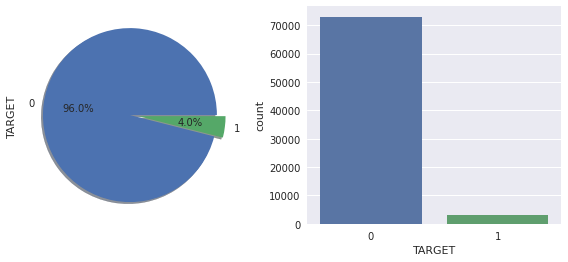

In [9]:
f, ax = plt.subplots(1,2,figsize=(10,4))
train_df['TARGET'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True
)
sns.countplot('TARGET', data=train_df, ax=ax[1])
plt.show()

In [10]:
null_value = train_df.isnull().sum().sort_values(ascending=False)
null_percent = round(train_df.isnull().sum().sort_values(ascending=False)/len(train_df)*100,2)
pd.concat([null_value, null_percent], axis=1, keys=['Null values', 'Percent'])

,Null values,Percent
TARGET,0,0.0
num_op_var41_ult1,0,0.0
num_var26,0,0.0
num_var25_0,0,0.0
num_var25,0,0.0
...,...,...
imp_trasp_var33_out_hace3,0,0.0
imp_trasp_var33_out_ult1,0,0.0
imp_venta_var44_hace3,0,0.0
imp_venta_var44_ult1,0,0.0


In [11]:
features[features.columns[:8]].corr()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1
var3,1.000000,-0.004452,0.001868,0.005989,0.006817,0.001518,0.001690,0.000530
var15,-0.004452,1.000000,0.043722,0.094762,0.101177,0.042754,0.048512,0.008805
imp_ent_var16_ult1,0.001868,0.043722,1.000000,0.041221,0.034879,0.009896,0.009377,0.000592
imp_op_var39_comer_ult1,0.005989,0.094762,0.041221,1.000000,0.886476,0.342709,0.295295,0.032280
imp_op_var39_comer_ult3,0.006817,0.101177,0.034879,0.886476,1.000000,0.316671,0.355670,0.029094
imp_op_var40_comer_ult1,0.001518,0.042754,0.009896,0.342709,0.316671,1.000000,0.852206,0.061187
imp_op_var40_comer_ult3,0.001690,0.048512,0.009377,0.295295,0.355670,0.852206,1.000000,0.053579
imp_op_var40_efect_ult1,0.000530,0.008805,0.000592,0.032280,0.029094,0.061187,0.053579,1.000000


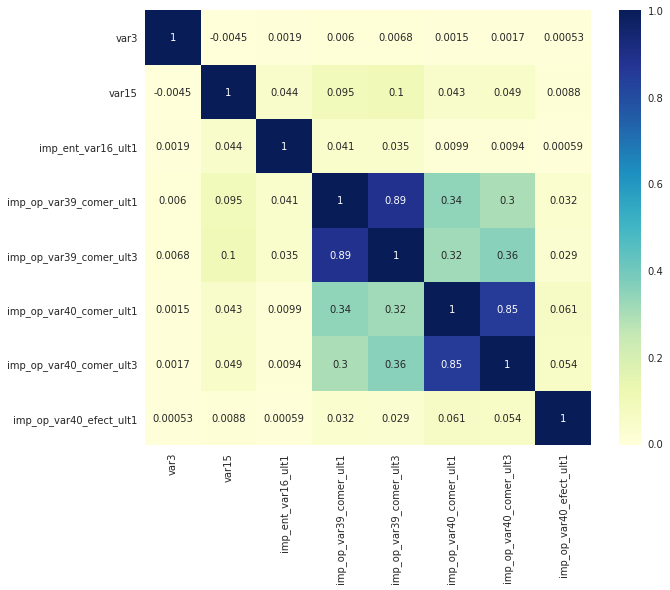

In [12]:
sns.heatmap(features[features.columns[:8]].corr(),annot=True,cmap='YlGnBu')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

=> We Can Check Multicollinearity

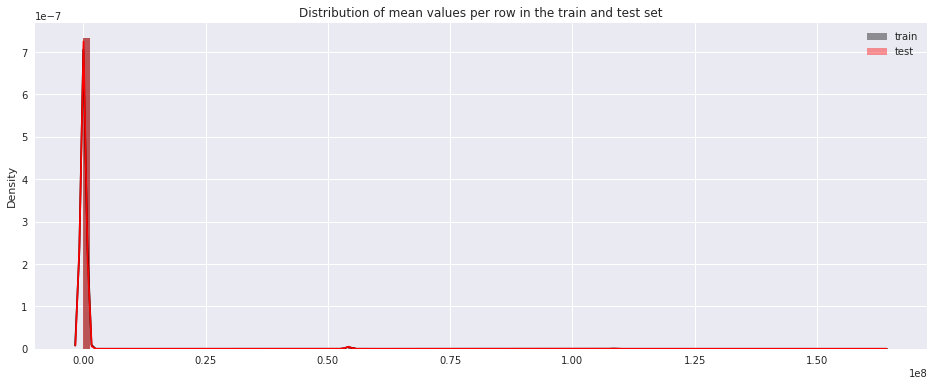

In [13]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features.columns].mean(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features.columns].mean(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

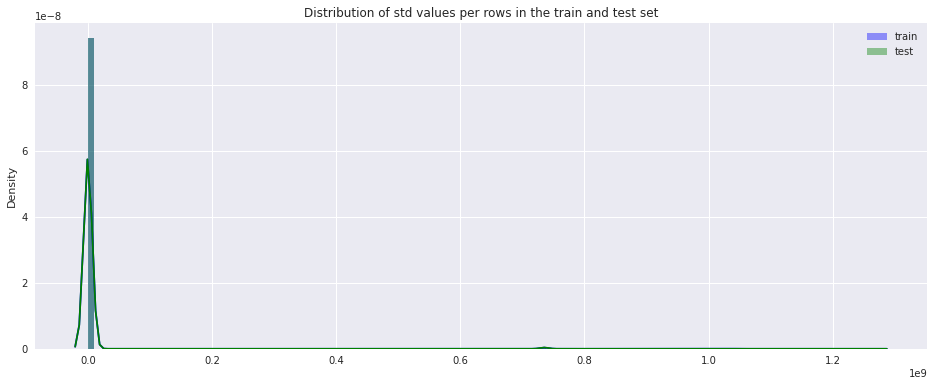

In [14]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per rows in the train and test set")
sns.distplot(train_df[features.columns].std(axis=1),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features.columns].std(axis=1),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

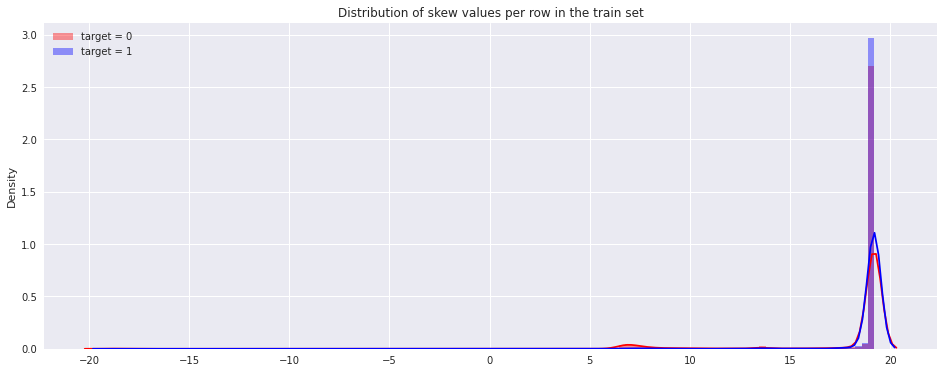

In [15]:
t0 = train_df[train_df['TARGET'] == 0]
t1 = train_df[train_df['TARGET'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features.columns].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features.columns].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

=> We Can Check Outlier

In [16]:
train_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc714643d50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc714635d50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc7146430d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc714628910>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc714628850>],
 'means': []}

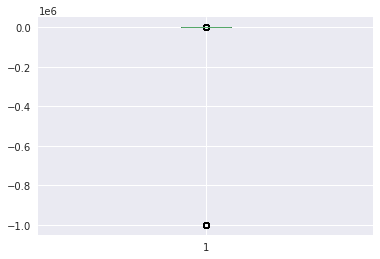

In [17]:
plt.boxplot(train_df['var3'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc7145878d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc7145105d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc714587510>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc714519290>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc714519990>],
 'means': []}

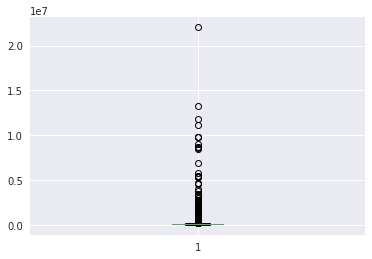

In [18]:
plt.boxplot(train_df['var38'])

# Preprocessing
* Processing Outlier Values

In [19]:
train_df['var3'].replace(-999999,2,inplace=True)
train_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,2.716483,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,9.447971,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


# Feature Engineering
* Split Data to Train / Test 
* Train Data to Standard Scaler
* Target Data to Oversampling by SMOTE

In [20]:
train_df.drop('ID',axis=1,inplace=True)
test_df.drop('ID',axis=1,inplace=True)

In [21]:
x = train_df.drop('TARGET',axis=1)
y = train_df['TARGET']

In [22]:
scaler = StandardScaler().fit(x)
x_scaler = scaler.transform(x)
test_df_scler = scaler.transform(test_df)
x_scaler_df = pd.DataFrame(x_scaler, columns=x.columns)

In [23]:
pca = PCA(n_components=0.95)
x_scaler_pca = pca.fit_transform(x_scaler)
x_scaler_pca_df = pd.DataFrame(x_scaler_pca)

In [24]:
x_scaler_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.674145,-1.554275,-0.208119,0.281410,0.164041,1.350834,0.160862,-0.115949,-0.029225,-0.196244,...,-0.064338,-0.171155,-0.143007,0.012559,-0.011739,0.094623,-0.019372,-0.026646,-0.035459,0.020311
1,-0.960521,7.752362,-4.106652,5.334768,2.385043,0.218341,0.133414,0.049123,-0.556414,-0.166837,...,0.766588,-0.308978,0.503549,0.719637,-0.275620,0.127514,0.409062,0.184099,-0.448965,0.320545
2,-1.986447,-0.934208,0.009955,-0.080542,0.109740,-0.162644,0.014606,-0.116430,0.041589,0.070014,...,-0.139155,0.271461,0.155290,0.115685,0.208813,0.074755,-0.045338,0.123473,0.893015,-0.667017
3,4.439496,-1.457601,0.036698,-0.104464,-0.232233,-2.798434,-0.389224,0.137367,0.160411,0.296752,...,-0.480409,0.099165,0.499151,0.148508,0.060842,-0.096960,0.117620,0.259210,-0.120035,0.193365
4,2.078684,8.541310,3.888339,-10.484813,-5.649927,1.674919,-0.269189,0.813126,-0.521450,0.028506,...,0.697077,-2.086193,-1.250446,-0.445839,-0.150258,0.738608,-0.187255,0.019829,-0.319196,0.006682


In [25]:
pca.explained_variance_ratio_

array([0.08084426, 0.05228955, 0.03647597, 0.03479578, 0.03418844,
       0.0312059 , 0.02941499, 0.02827235, 0.02609924, 0.02561362,
       0.02258139, 0.0213216 , 0.02111292, 0.02044311, 0.01988079,
       0.01751307, 0.01632014, 0.01558715, 0.01391018, 0.01323561,
       0.01292253, 0.01234885, 0.01223925, 0.01180389, 0.01076486,
       0.01060342, 0.01031062, 0.01010831, 0.00997942, 0.00964471,
       0.00953121, 0.00935437, 0.00915166, 0.00874128, 0.00847179,
       0.00803298, 0.00737756, 0.00715547, 0.00676623, 0.00670803,
       0.00648847, 0.00625966, 0.0062385 , 0.00607502, 0.00601847,
       0.00599934, 0.00581773, 0.00578601, 0.00569563, 0.00552583,
       0.00521093, 0.00509666, 0.00453945, 0.00435819, 0.00429771,
       0.00412857, 0.00411041, 0.00395858, 0.00389107, 0.00382694,
       0.00369233, 0.00364883, 0.00355661, 0.00341691, 0.00330774,
       0.00310196, 0.0030283 , 0.00297678, 0.00294249, 0.00283271,
       0.00279356, 0.00277341, 0.00267043, 0.00255626, 0.00252

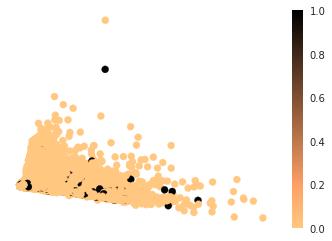

In [26]:
plt.scatter(x_scaler_pca_df.loc[:, 0], x_scaler_pca_df.loc[:, 1], c=y,  cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

=> We cant use PCA

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [28]:
scaler_x_train, scaler_x_test, scaler_y_train, scaler_y_test = train_test_split(x_scaler, y, test_size=0.3)

<AxesSubplot:title={'center':'Count_target'}>

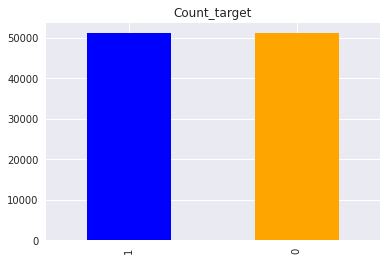

In [29]:
smote = SMOTE()
x_over, y_over = smote.fit_resample(scaler_x_train,scaler_y_train)
y_over.value_counts().plot(kind='bar',title='Count_target',color=['blue','orange'])

# Modeling
* LogisticRegression
* LightGBM Classification

In [30]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuacy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('confusion')
    print(confusion)
    print('Accuacy : {}'.format(np.around(accuacy,4)))
    print('Precision: {}'.format(np.around(precision,4)))
    print('Recall : {}'.format(np.around(recall,4)))
    print('F1 : {}'.format(np.around(f1,4)))  
    print('ROC_AUC : {}'.format(np.around(roc_auc,4)))

* LogisticRegression 

In [31]:
lg_reg = LogisticRegression()

lg_reg.fit(x_over, y_over)
pred = lg_reg.predict(scaler_x_test)
pred_proba = lg_reg.predict_proba(scaler_x_test)[:,1]
get_clf_eval(scaler_y_test, pred, pred_proba)

confusion
[[15330  6559]
 [  242   675]]
Accuacy : 0.7018
Precision: 0.0933
Recall : 0.7361
F1 : 0.1656
ROC_AUC : 0.7897


* LightGBM Classifier

In [32]:
scaler_x_test, scaler_x_val, scaler_y_test, scaler_y_val = train_test_split(scaler_x_test, scaler_y_test, test_size=0.5)

In [33]:
train_data = lgb.Dataset(x_over, label=y_over)
val_data = lgb.Dataset(scaler_x_val, label=scaler_y_val)
params = {
    'n_estimators': 5000,
    'num_leaves': 20,
    'max_depth': -1,
    'min_data_in_leaf': 80,
    'learning_rate': 0.001,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'n_jobs': -1
}

In [34]:
model = lgb.train(params,
                  train_data,
                  valid_sets=val_data, 
                  valid_names=['train','valid'],
                  early_stopping_rounds=300)

[LightGBM] [Info] Number of positive: 51123, number of negative: 51123
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36158
[LightGBM] [Info] Number of data points in the train set: 102246, number of used features: 225
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	train's auc: 0.788042
Training until validation scores don't improve for 300 rounds
[2]	train's auc: 0.788042
[3]	train's auc: 0.788042
[4]	train's auc: 0.788042
[5]	train's auc: 0.788042
[6]	train's auc: 0.788042
[7]	train's auc: 0.788042
[8]	train's auc: 0.788042
[9]	train's auc: 0.788042
[10]	train's auc: 0.788042
[11]	train's auc: 0.788042
[12]	train's auc: 0.788042
[13]	train's auc: 0.788042
[14]	train's auc: 0.788042
[15]	train's auc: 0.788042
[16]	train's auc: 0.788042
[17]	t

# Submission

In [35]:
submission = pd.read_csv('/kaggle/input/santander-customer-satisfaction/sample_submission.csv')
submission.head()

,ID,TARGET
0,2,0
1,5,0
2,6,0
3,7,0
4,9,0


In [36]:
target = model.predict(test_df_scler)

In [37]:
submission['TARGET'] = target

In [38]:
submission.to_csv('submission.csv', index=False)